In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import linear_regression
import matplotlib.pyplot as plt
import plorts

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from matplotlib.lines import Line2D

import energy_analysis_helpers

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rhxza9mq because the default path (/home/sarslan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
FIG_SIZE = (8,5)
FIG_SIZE_HALF = (4,4.7)
plt.rcParams["figure.figsize"] = FIG_SIZE
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

In [3]:
N_CORES_TOT = 32

EXP_ID = '240229-1449'
data_folder = '../data/' + EXP_ID + '/'
exp_filename = data_folder + 'energy.log'

if (SAVE_FIG):
    out_dir = '../outputs/' + EXP_ID + '/'
    if (not os.path.exists(out_dir)):
        os.mkdir(out_dir)

# Reading the Experiment Data

In [4]:
exp_df = energy_analysis_helpers.read_energy_log(exp_filename)
exp_df['energy_J'] = exp_df['energy_uJ'] / 1000000
exp_df = energy_analysis_helpers.read_iperf_log(exp_df, data_folder)
exp_df

../data/240229-1449/cubic_9000_1_10_1_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_2_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_3_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_4_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_5_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_6_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_7_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_8_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_9_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_10_10_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_1_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_2_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_3_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_4_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_5_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_6_0.json doesn't exist!
../data/240229-1449/cubic_9000_1_20_7_0

,cc,mtu,bitrate,n_core,duration,cnt,energy_uJ,energy_J,total_cpu_util_percent,user_cpu_util_percent,system_cpu_util_percent,time_sec,sent_bytes,bps,rtx_pkts,min_rtt,mean_rtt,max_rtt,max_cwnd
0,stress,9000,0,0,10.0,1,2.261754e+08,226.175446,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stress,9000,0,0,10.0,2,2.338184e+08,233.818371,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stress,9000,0,0,10.0,3,2.224779e+08,222.477946,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,stress,9000,0,0,10.0,4,2.254433e+08,225.443271,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stress,9000,0,0,10.0,5,2.244875e+08,224.487525,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,cubic,9000,10,0,100.0,6,3.547349e+09,3547.348768,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4316,cubic,9000,10,0,100.0,7,3.576495e+09,3576.495178,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4317,cubic,9000,10,0,100.0,8,3.544183e+09,3544.183066,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4318,cubic,9000,10,0,100.0,9,3.543709e+09,3543.708823,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Energy Consumption Analysis

In [5]:
energy_per_time_df = []
for cca, df in exp_df.groupby('cc'):
    if (cca in ['stress', 'sleep']):
        for n_core, ddf in df.groupby('n_core'):
            slope, _ = linear_regression(ddf['time_sec'], ddf['energy_J'], proportional=True)
            energy_per_time_df.append([cca, 0, n_core, slope])
    else:
        for bitrate, ddf in df.groupby('bitrate'):
            for n_core, dddf in ddf.groupby('n_core'):
                slope, _ = linear_regression(dddf['time_sec'], dddf['energy_J'], proportional=True)
                energy_per_time_df.append([cca, bitrate, n_core, slope])
energy_per_time_df = pd.DataFrame(energy_per_time_df, columns=['cc', 'bitrate', 'n_core', 'power_W'])
# energy_per_time_df

In [6]:
overhead_energy = \
    energy_per_time_df[energy_per_time_df.cc=='stress'][['n_core', 'power_W']].copy().set_index('n_core').to_dict()['power_W']
energy_per_time_df['power_W_noOverhead'] = \
    energy_per_time_df.apply(lambda row: row['power_W'] - overhead_energy[row['n_core']], axis=1)
energy_per_time_df

,cc,bitrate,n_core,power_W,power_W_noOverhead
0,cubic,1,0,31.715786,10.118237
1,cubic,1,8,90.601817,-0.144576
2,cubic,1,16,110.486391,-0.094711
3,cubic,1,24,114.899013,0.413784
4,cubic,2,0,32.241543,10.643994
5,cubic,2,8,90.953604,0.207211
6,cubic,2,16,110.063244,-0.517858
7,cubic,2,24,115.109737,0.624507
8,cubic,3,0,32.811402,11.213853
9,cubic,3,8,91.217243,0.470850


In [7]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='power_W')
print('=== Power Consumption of Traffic and Background Cores (W) ===\n')
print(matrix)

=== Power Consumption of Traffic and Background Cores (W) ===

n_core          0          8           16          24
bitrate                                              
0        21.597549  90.746393  110.581102  114.485230
1        31.715786  90.601817  110.486391  114.899013
2        32.241543  90.953604  110.063244  115.109737
3        32.811402  91.217243  111.490196  115.397443
4        33.340595  91.593690  111.811641  115.610263
5        33.985667  91.289361  111.700812  115.819293
6        34.392578  91.927157  111.857482  116.075491
7        34.802827  92.097715  112.498459  116.354566
8        35.172776  92.596180  112.514996  116.670404
9        35.866247  92.634922  112.338239  116.647509
10       35.548366  92.898000  112.162583  116.529808


In [8]:
matrix = energy_per_time_df.pivot(index='bitrate', columns='n_core', values='power_W_noOverhead')
print('=== Power Consumption of Traffic Only (W) ===\n')
print(matrix)

=== Power Consumption of Traffic Only (W) ===

n_core          0         8         16        24
bitrate                                         
0         0.000000  0.000000  0.000000  0.000000
1        10.118237 -0.144576 -0.094711  0.413784
2        10.643994  0.207211 -0.517858  0.624507
3        11.213853  0.470850  0.909094  0.912213
4        11.743046  0.847297  1.230539  1.125034
5        12.388118  0.542968  1.119710  1.334063
6        12.795030  1.180764  1.276380  1.590261
7        13.205278  1.351322  1.917357  1.869337
8        13.575227  1.849787  1.933894  2.185174
9        14.268698  1.888529  1.757137  2.162279
10       13.950818  2.151607  1.581481  2.044579


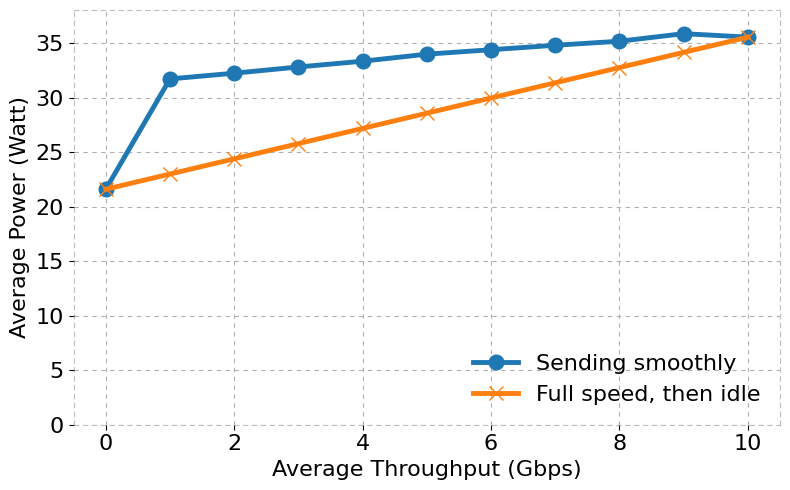

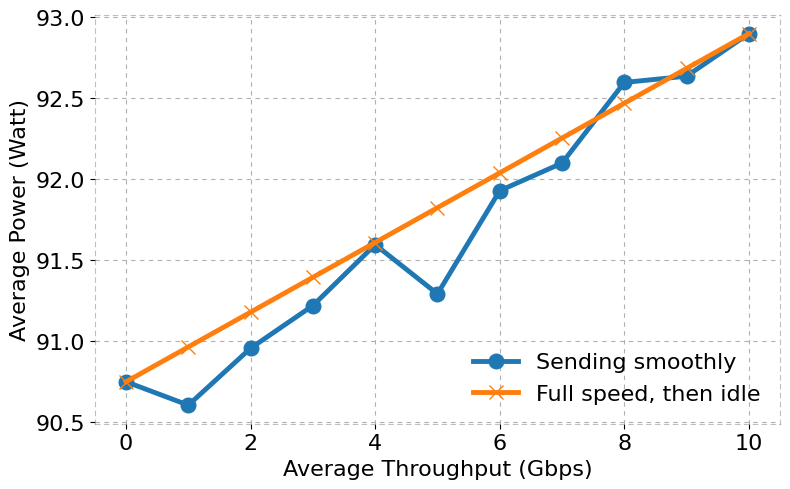

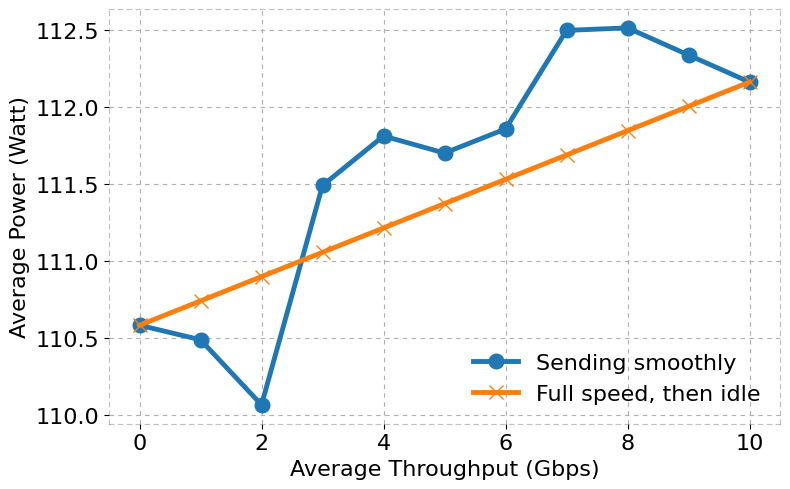

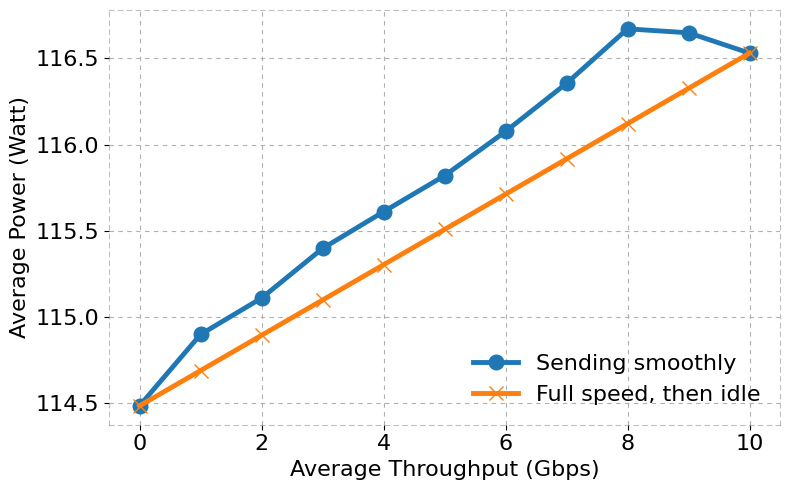

In [9]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_power_W = df[df.bitrate == 0].power_W.iloc[0]
    max_power_W = df[df.bitrate == 10].power_W.iloc[0]
    df['power_W_per_gb'] = df.power_W*1/df.bitrate + idle_power_W*(1 - 1/df.bitrate)
    df['W_full_speed'] = max_power_W*df.bitrate/10. + idle_power_W*(1 - df.bitrate/10.)

    plt.figure(figsize=FIG_SIZE)
    plt.plot(df.bitrate, df.power_W, marker='o', label='Sending smoothly', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.plot(df.bitrate, df.W_full_speed, marker='x', label='Full speed, then idle', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
    plt.ylabel("Average Power (Watt)", fontsize=FONT_SIZE)
    plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
    plt.legend(loc='best')
    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    if (n_core == 0):
        plt.ylim((0,df.W_full_speed.max()*1.07))
    plt.xticks(rotation = 0)
    plt.grid(linestyle=LINE_STYLE)
    leg = plt.gca().legend(loc='lower right', frameon=False, fontsize=FONT_SIZE)
    # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
    plt.gca().spines["right"].set_linestyle(LINE_STYLE)
    plt.gca().spines["right"].set_alpha(0.5)
    plt.gca().spines["right"].set_color('gray')
    plt.gca().spines["left"].set_linestyle(LINE_STYLE)
    plt.gca().spines["left"].set_alpha(0.5)
    plt.gca().spines["left"].set_color('gray')
    # plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["top"].set_linestyle(LINE_STYLE)
    plt.gca().spines["top"].set_alpha(0.5)
    plt.gca().spines["top"].set_color('gray')
    # plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["bottom"].set_color('gray')

    plt.tight_layout()
    # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

    if (SAVE_FIG):
        plt.savefig( out_dir + '/smooth_vs_bursty_{}_cores.pdf'.format(n_core))

    plt.show()

In [10]:
# for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
#     idle_kJps = df[df.bitrate == 0].kJps.iloc[0]
#     max_kJps = df[df.bitrate == 10].kJps.iloc[0]
#     df['kJ_per_gb'] = df.kJps*1/df.bitrate + idle_kJps*(1 - 1/df.bitrate)
#     df['kJ_full_speed'] = max_kJps*df.bitrate/10. + idle_kJps*(1 - df.bitrate/10.)

#     plt.figure(figsize=FIG_SIZE)
#     plt.plot(df.bitrate, df.kJps, marker='o',
#              linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)
#     plt.ylabel("Average Rate of Energy (KJ/sec)", fontsize=FONT_SIZE)
#     plt.xlabel("Average Throughput (Gbps)", fontsize=FONT_SIZE)
#     plt.xticks(fontsize=FONT_SIZE)
#     plt.yticks(fontsize=FONT_SIZE)
#     if (n_core == 0):
#         plt.ylim((0,df.kJ_full_speed.max()*1.07))
#     plt.xticks(rotation = 0)
#     plt.grid(linestyle=LINE_STYLE)
#     # plt.setp(leg.get_title(),fontsize=FONT_SIZE)
#     plt.gca().spines["right"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["right"].set_alpha(0.5)
#     plt.gca().spines["right"].set_color('gray')
#     plt.gca().spines["left"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["left"].set_alpha(0.5)
#     plt.gca().spines["left"].set_color('gray')
#     # plt.gca().spines["top"].set_visible(False)
#     plt.gca().spines["top"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["top"].set_alpha(0.5)
#     plt.gca().spines["top"].set_color('gray')
#     # plt.gca().spines["bottom"].set_visible(False)
#     plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
#     plt.gca().spines["bottom"].set_alpha(0.5)
#     plt.gca().spines["bottom"].set_color('gray')

#     plt.tight_layout()
#     # plt.subplots_adjust(right=0.3, top=0.1, bottom=0.05)

#     plt.show()

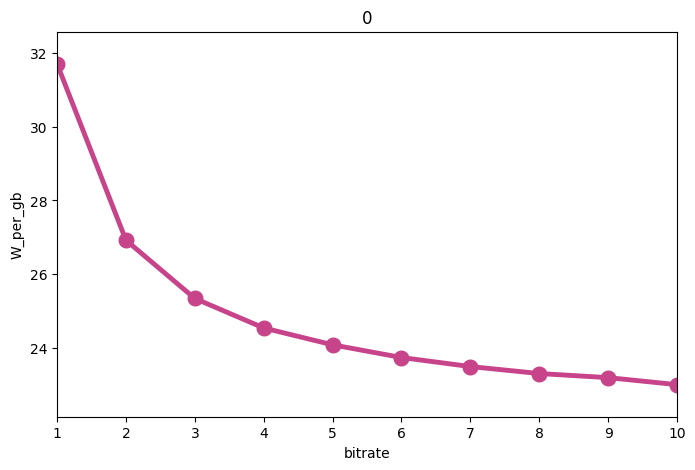

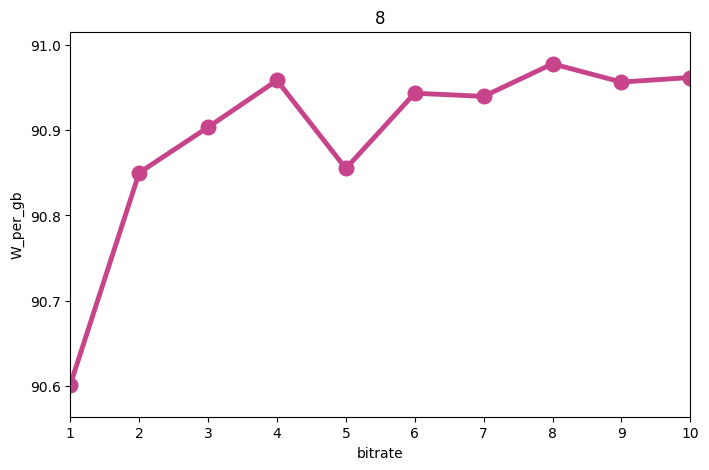

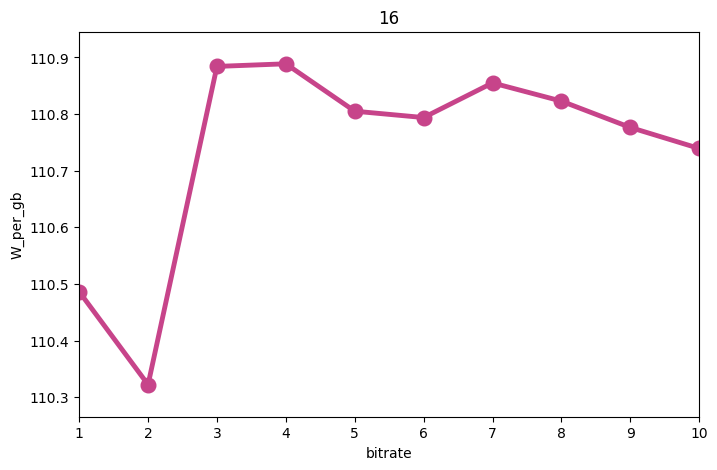

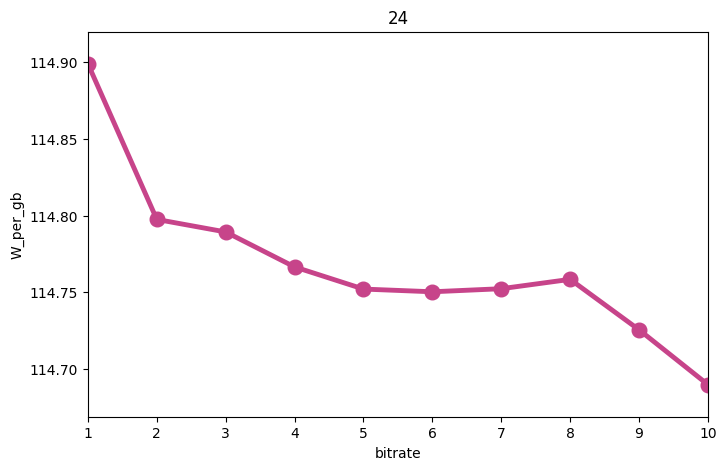

In [11]:
for n_core,df in energy_per_time_df.sort_values(by='bitrate').groupby('n_core'):
    idle_power_W = df[df.bitrate == 0].power_W.iloc[0]
    df['W_per_gb'] = df.power_W*1/df.bitrate + idle_power_W*(1 - 1/df.bitrate)
    plt.figure()
    plt.title(n_core)
    plorts.plot(df, x='bitrate', y='W_per_gb', marker='o', 
                linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

In [12]:
energy_per_bitrate = {}
for _,row in energy_per_time_df[energy_per_time_df.n_core == 0].iterrows():
    energy_per_bitrate[row.bitrate] = row.power_W
energy_per_bitrate

{1: 31.715785744545453,
 2: 32.241542993866666,
 3: 32.81140157111688,
 4: 33.340594942535944,
 5: 33.985666662930804,
 6: 34.39257836872727,
 7: 34.80282664236693,
 8: 35.17277567711688,
 9: 35.866246830155845,
 10: 35.54836631513456,
 0: 21.597548772088086}

In [13]:
capacity = 10
file_size = capacity
duration = 2 * file_size / capacity
df = []
for fg_share_gbps in range(0,11):
    bg_share_gbps = capacity - fg_share_gbps
    if bg_share_gbps < fg_share_gbps:
        fct = file_size / fg_share_gbps
    else:
        fct = file_size / bg_share_gbps
        
    fg_left_to_send = file_size - fg_share_gbps * fct
    fg_full_time = fg_left_to_send / capacity
    fg_idle_time = duration - fct - fg_full_time
    fg_energy = energy_per_bitrate[fg_share_gbps]*fct + energy_per_bitrate[0]*fg_idle_time + energy_per_bitrate[10] * fg_full_time
    bg_left_to_send = file_size - bg_share_gbps*fct
    bg_full_time = bg_left_to_send / capacity
    bg_idle_time = duration - fct - bg_full_time
    bg_energy = energy_per_bitrate[bg_share_gbps]*fct + energy_per_bitrate[0]*bg_idle_time + energy_per_bitrate[10]*bg_full_time
    df.append({
        'capacity': capacity,
        'fct': fct,
        'fg_share_gbps':fg_share_gbps,
        'fg_idle_time':fg_idle_time,
        'fg_full_time': fg_full_time,
        'fg_energy':fg_energy,
        'bg_share_gbps':bg_share_gbps,
        'bg_left_to_send':bg_left_to_send,
        'bg_full_time':bg_full_time,
        'bg_idle_time':bg_idle_time,
        'bg_energy':bg_energy
    })
df = pd.DataFrame(df)
df['total_energy'] = df['fg_energy'] + df['bg_energy']
df

,capacity,fct,fg_share_gbps,fg_idle_time,fg_full_time,fg_energy,bg_share_gbps,bg_left_to_send,bg_full_time,bg_idle_time,bg_energy,total_energy
0,10,1.000000,0,0.000000e+00,1.000000,57.145915,10,0.000000,0.000000,1.000000e+00,57.145915,114.291830
1,10,1.111111,1,-1.110223e-16,0.888889,66.838310,9,0.000000,0.000000,8.888889e-01,59.049206,125.887516
2,10,1.250000,2,0.000000e+00,0.750000,66.963203,8,0.000000,0.000000,7.500000e-01,60.164131,127.127335
3,10,1.428571,3,0.000000e+00,0.571429,67.186783,7,0.000000,0.000000,5.714286e-01,62.059780,129.246563
4,10,1.666667,4,-5.551115e-17,0.333333,67.417114,6,0.000000,0.000000,3.333333e-01,64.520147,131.937261
5,10,2.000000,5,0.000000e+00,0.000000,67.971333,5,0.000000,0.000000,0.000000e+00,67.971333,135.942667
6,10,1.666667,6,3.333333e-01,0.000000,64.520147,4,3.333333,0.333333,-5.551115e-17,67.417114,131.937261
7,10,1.428571,7,5.714286e-01,0.000000,62.059780,3,5.714286,0.571429,0.000000e+00,67.186783,129.246563
8,10,1.250000,8,7.500000e-01,0.000000,60.164131,2,7.500000,0.750000,0.000000e+00,66.963203,127.127335
9,10,1.111111,9,8.888889e-01,0.000000,59.049206,1,8.888889,0.888889,-1.110223e-16,66.838310,125.887516


(0.0, 10.0, 0.0, 138.107750299451)

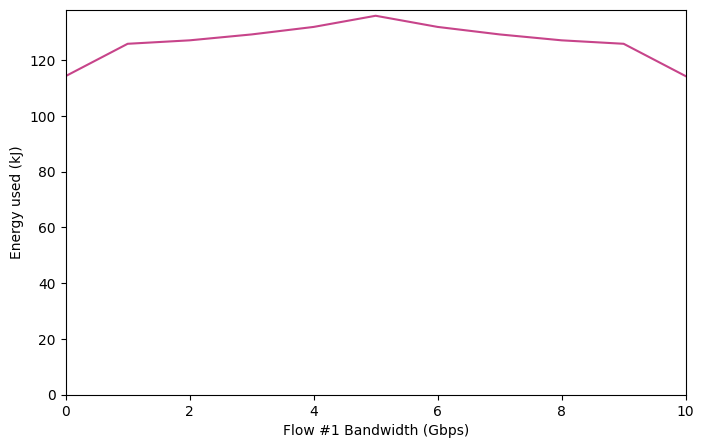

In [14]:
plorts.plot(df, x="fg_share_gbps", y='total_energy')
plt.xlabel("Flow #1 Bandwidth (Gbps)")
plt.ylabel("Energy used (kJ)")
plt.axis(ymin=0)

In [15]:
# fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
# df['energy_savings_pct'] = 100.0*(df['total_energy'] - fair_energy)/fair_energy
# df['fg_share_pct'] = 10*df['fg_share_gbps']

# plorts.plot(df, x="fg_share_pct", y='energy_savings_pct')
# plt.ylabel("% energy used over fair share")
# plt.xlabel("% bandwidth used by Flow #1")
# plt.axhline(y=0, linestyle=":", color='grey')
# plt.axvline(x=50, linestyle=":", color='grey')
# plt.text(52, -10, "Fair share", size=15)
# plorts.style_axis()

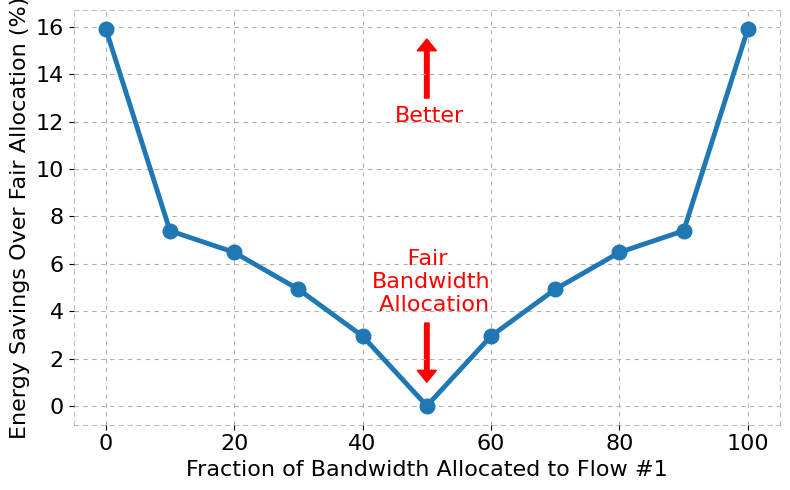

In [16]:
fair_energy = df[df.fg_share_gbps == 5].iloc[0].total_energy
df['energy_savings_pct'] = 100.0*(fair_energy - df['total_energy'])/fair_energy
df['fg_share_pct'] = 10*df['fg_share_gbps']

plt.figure(figsize=FIG_SIZE)
plt.plot(df.fg_share_pct, df.energy_savings_pct, marker='o', 
             linewidth=LINE_WIDTH, markersize=LINE_WIDTH*3)

plt.ylabel("Energy Savings Over Fair Allocation (%)", fontsize=FONT_SIZE)
plt.xlabel("Fraction of Bandwidth Allocated to Flow #1", fontsize=FONT_SIZE)
plt.arrow(50, 3.5, 0, -2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(41.5, 4, "     Fair\nBandwidth\n Allocation", size=FONT_SIZE, color='red')
plt.arrow(50, 13, 0, 2, head_width=3, color='red', head_length=0.5, width=0.7)
plt.text(45, 12, "Better", size=FONT_SIZE, color='red')

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
# plt.gca().spines["top"].set_visible(False)
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/fairness_vs_energy.pdf')

plt.show()

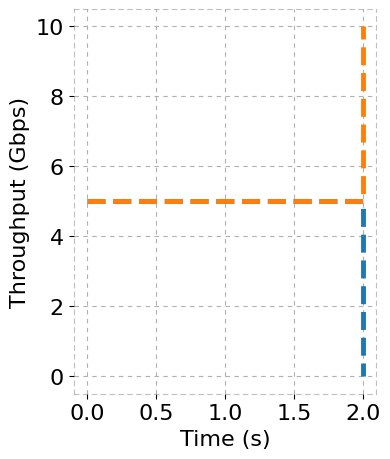

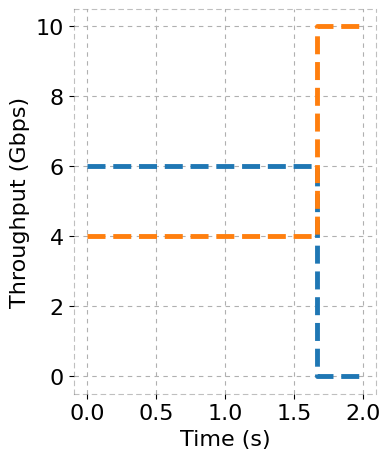

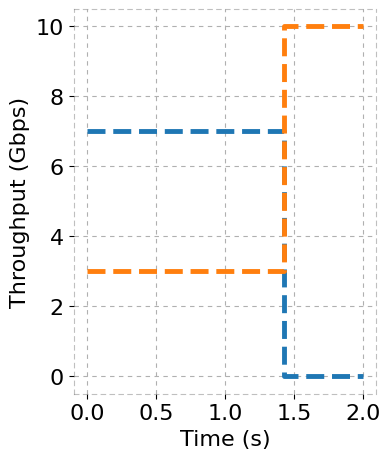

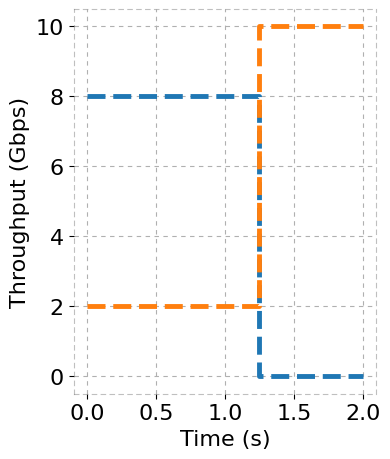

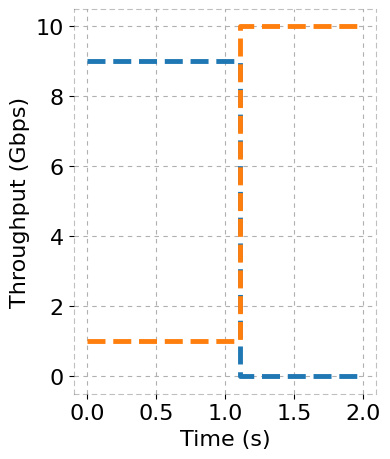

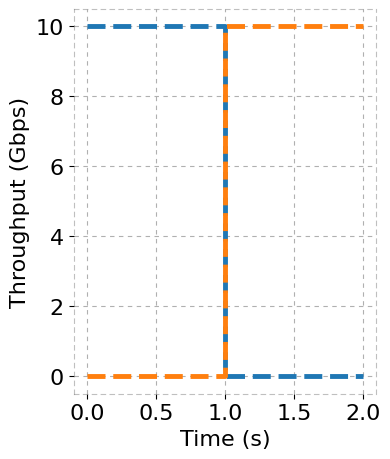

In [17]:
for _,exp in df.iterrows():
    if exp.fg_share_gbps < 5: continue
    plt.figure(figsize=FIG_SIZE_HALF)
    # plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.fg_share_gbps, exp.fg_share_gbps, 0, 0],
             '--', label="Flow #1", linewidth=LINE_WIDTH)
    plt.plot([0, exp.fct, exp.fct, exp.fct + exp.bg_full_time], [exp.bg_share_gbps, exp.bg_share_gbps, exp.capacity, exp.capacity],
             '--', label="Flow #2", linewidth=LINE_WIDTH)
    plt.xlabel("Time (s)", fontsize=FONT_SIZE)
    plt.ylabel("Throughput (Gbps)", fontsize=FONT_SIZE)

    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)
    plt.grid(linestyle=LINE_STYLE)
    plt.gca().spines["right"].set_linestyle(LINE_STYLE)
    plt.gca().spines["right"].set_alpha(0.5)
    plt.gca().spines["right"].set_color('gray')
    plt.gca().spines["left"].set_linestyle(LINE_STYLE)
    plt.gca().spines["left"].set_alpha(0.5)
    plt.gca().spines["left"].set_color('gray')
    # plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["top"].set_linestyle(LINE_STYLE)
    plt.gca().spines["top"].set_alpha(0.5)
    plt.gca().spines["top"].set_color('gray')
    # plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
    plt.gca().spines["bottom"].set_alpha(0.5)
    plt.gca().spines["bottom"].set_color('gray')

    plt.tight_layout()

    if (SAVE_FIG):
        plt.savefig( out_dir + '/experiment_trace_{:.0f}_gbps.pdf'.format(exp.fg_share_gbps))
    
    plt.show()

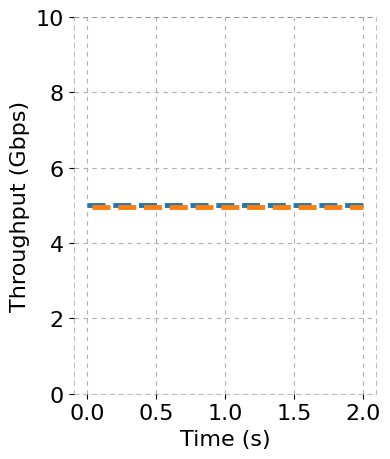

In [18]:
exp = df.iloc[5]

plt.figure(figsize=FIG_SIZE_HALF)
# plt.title(f"Flow #1 share: {exp.fg_share_gbps.astype(int)} Gbps")
plt.plot([0, exp.fct], [exp.fg_share_gbps, exp.fg_share_gbps], '--', label="Flow #1", linewidth=LINE_WIDTH)
plt.plot([0.03, exp.fct], [exp.bg_share_gbps-0.05, exp.bg_share_gbps-0.05], '--', label="Flow #2", linewidth=LINE_WIDTH)
plt.axis(ymin=0,ymax=10)
plt.xlabel("Time (s)", fontsize=FONT_SIZE)
plt.ylabel("Throughput (Gbps)", fontsize=FONT_SIZE)

plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
# plt.gca().spines["top"].set_visible(False)
plt.gca().spines["top"].set_linestyle(LINE_STYLE)
plt.gca().spines["top"].set_alpha(0.5)
plt.gca().spines["top"].set_color('gray')
# plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
        plt.savefig( out_dir + f'/experiment_trace_{exp.fg_share_gbps.astype(int)}_gbps.pdf')

plt.show()